In [245]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import fmin_bfgs, fmin_cg
np.set_printoptions(precision=2, linewidth=120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Immediately have to address this issue: sampling Qval needs to be Haar-uniform.

In [3]:
def testFAC(M):
    l = np.linalg.svd(M)[1]
    t1 = (1 - l[2]) >= np.abs(l[0] - l[1])
    t2 = (1 + l[2]) >= np.abs(l[0] + l[1])
    return t1 & t2

def tomogn(Mval, n):
    mval = 0.5 * (1 - np.diag(Mval))
    T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    Tinv = np.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]])
    pval = np.dot(Tinv, mval)
    pval = np.r_[1-np.sum(pval), pval]
    e = np.random.multinomial(n, pval)
    p = e / float(n)
    Mhat = np.diag(1.0 - 2.0 * np.dot(T, p[1:]))
    return Mhat

def eventomog(Mval, n=100, d=0.01):
    L1 = np.array([[np.cos(d), -np.sin(d), 0], [np.sin(d), np.cos(d), 0], [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    Mval1 = np.dot(np.dot(L1, Mval), L1.T)
    Mval2 = np.dot(np.dot(L2, Mval), L2.T)
    Mval3 = np.dot(np.dot(L3, Mval), L3.T)
    S1 = tomogn(Mval1, n)
    S2 = tomogn(Mval2, n)
    S3 = tomogn(Mval3, n)
    Mhat1 = np.dot(np.dot(L1.T, S1), L1)
    Mhat2 = np.dot(np.dot(L2.T, S2), L2)
    Mhat3 = np.dot(np.dot(L3.T, S3), L3)
    M = 1.0/3.0 * (Mhat1 + Mhat2 + Mhat3)
    return M

## Sanity check: perfect tomography

In [4]:
def perfecttomog(Mval, d=0.01):
    L1 = np.array([[np.cos(d), -np.sin(d), 0], [np.sin(d), np.cos(d), 0], [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    Mval1 = np.dot(np.dot(L1, Mval), L1.T)
    Mval2 = np.dot(np.dot(L2, Mval), L2.T)
    Mval3 = np.dot(np.dot(L3, Mval), L3.T)
    S1 = np.diag(np.diag(Mval1))
    S2 = np.diag(np.diag(Mval2))
    S3 = np.diag(np.diag(Mval3))
    Mhat1 = np.dot(np.dot(L1.T, S1), L1)
    Mhat2 = np.dot(np.dot(L2.T, S2), L2)
    Mhat3 = np.dot(np.dot(L3.T, S3), L3)
    M = 1.0/3.0 * (Mhat1 + Mhat2 + Mhat3)
    return M

In [63]:
ncycles = []
dist = []
svd_dist = []
Qnormdiffs = []
FACs = []
ds = []
for d in 0.25*np.pi*np.logspace(0, -3, 4):
    for trial in range(1000):
        Qval, _ = np.linalg.qr(np.random.randn(3,3))
        Sval = np.diag([0.95, 0.9, 0.85])
        Mval = np.dot(np.dot(Qval, Sval), Qval.T)
        for n in np.logspace(1, 6, 30):
            Mhat = perfecttomog(Mval)
            Qhat = np.linalg.svd(Mhat)[0]
            Mhatvals = np.linalg.svd(Mhat)[1]
            Mvalvals = np.linalg.svd(Mval)[1]
            dist.append(np.linalg.norm(Mhat - Mval))
            ncycles.append(n)
            svd_dist.append(np.linalg.norm(Mhatvals - Mvalvals))
            ds.append(d)
            Qnormdiffs.append(np.linalg.norm(np.dot(Qhat.T, Qval) - np.eye(3)))
            FACs.append(testFAC(Mhat))

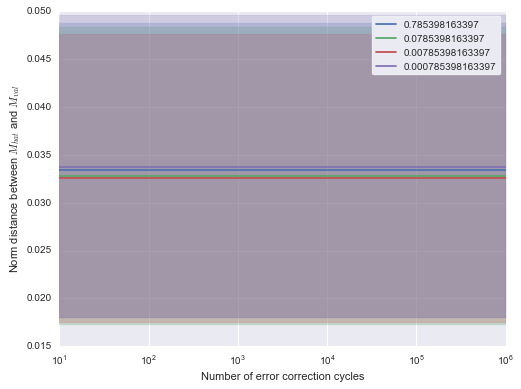

In [64]:
df = pd.DataFrame({"n": ncycles, "dist": svd_dist, "d": ds, "FAC": FACs})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.semilogx(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Number of error correction cycles")

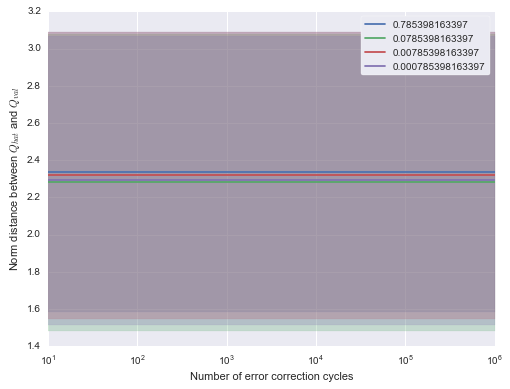

In [65]:
df = pd.DataFrame({"n": ncycles, "dist": Qnormdiffs, "d": ds, "FAC": FACs})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.semilogx(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $Q_{hat}$ and $Q_{val}$")
plt.xlabel("Number of error correction cycles")

## What is the operator through which we see the M matrix?

$$ (L_1^T \otimes L_1) \mathbb{P} (L_1 \otimes L_1^T) $$

In [366]:
def PLSX():
    PDIAG = np.zeros((9, 9))
    for esi in np.eye(3):
        one = np.kron(esi, esi)
        PDIAG = PDIAG + np.outer(one, one)
    PDIAG = PDIAG.astype(np.int)

    L1 = np.array([[np.cos(d), -np.sin(d), 0],
                   [np.sin(d), np.cos(d), 0],
                   [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)

    LL1 = np.kron(L1, L1.T)
    LL2 = np.kron(L2, L2.T)
    LL3 = np.kron(L3, L3.T)

    PL1 = np.dot(np.dot(LL1.T, PDIAG), LL1)
    PL2 = np.dot(np.dot(LL2.T, PDIAG), LL2)
    PL3 = np.dot(np.dot(LL3.T, PDIAG), LL3)

    X = np.r_[PL1, PL2, PL3]
#     sensors = [0, 4, 8, 9, 13, 17, 18, 22, 26]
#     indepvs = [0, 4, 8, 1, 2, 5]
#     X = X[sensors, :]
#     X = X[:, indepvs]
    return X

In [367]:
X = PLSX()

In [368]:
X.shape

(27, 9)

In [ ]:
qopt = fmin_cg(lambda q: cost(q, S, X),
                 np.random.random((9,1)),
                 disp=False)

In [357]:
np.sum(X, axis=0)

array([  3.00e+00,   1.57e-03,  -1.57e-03,  -1.57e-03,   3.00e+00,   1.57e-03,   1.57e-03,  -1.57e-03,   3.00e+00])

In [331]:
Qval = np.linalg.qr(np.random.randn(3,3))[0]
Mval = np.dot(np.dot(Qval, np.diag([0.33, 0.66, 0.99])), Qval.T)

a = np.dot(PLS, np.reshape(Mval, (9, 1)))

mhat = np.dot(np.linalg.pinv(X), a)
Mhat = np.reshape(mhat, (3, 3))

np.linalg.norm(Mval-Mhat)

0.40392607610928649

## Sanity check for random Q

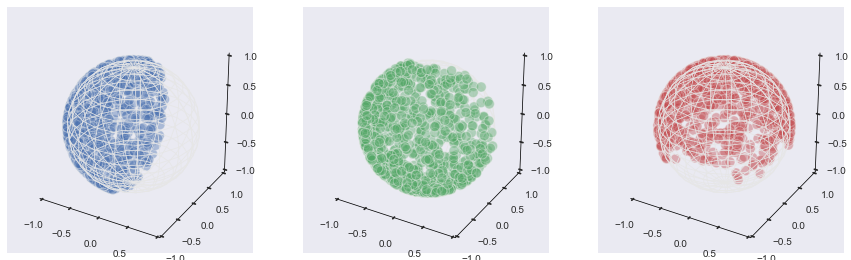

In [88]:
NUM_POINTS = 1000

fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(131, projection='3d')
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')
axs = [ax0, ax1, ax2]

for ax in axs:
    ax.set_aspect("equal")
    ax.set_frame_on(False)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.grid(False)

    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
    x=np.cos(u)*np.sin(v)
    y=np.sin(u)*np.sin(v)
    z=np.cos(v)
    ax.plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)

Q = np.zeros((NUM_POINTS, 9))
for k in range(NUM_POINTS):
    q = np.reshape(np.linalg.qr(np.random.randn(3,3))[0], (9,))
    Q[k, :] = q

axs[0].scatter(Q[:, 0], Q[:, 1], Q[:, 2], s=100, alpha=0.4,
               c=sns.color_palette()[0], marker="o", linewidth=1.0)
axs[1].scatter(Q[:, 3], Q[:, 4], Q[:, 5], s=100, alpha=0.4,
               c=sns.color_palette()[1], marker="o", linewidth=1.0)
axs[2].scatter(Q[:, 6], Q[:, 7], Q[:, 8], s=100, alpha=0.4,
               c=sns.color_palette()[2], marker="o", linewidth=1.0)

for ax in axs:
    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])

The first component doesn't get negative signs